# Test de reconnaissance des champignons avec le CNN LeNet5 de Yann Lecun

## Import des librairies

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import pathlib
import itertools
import random

import PIL
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical

print("tensorflow version",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-07-26 11:53:42.811603: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 11:53:42.814533: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 11:53:42.824745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 11:53:42.842010: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 11:53:42.847059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 11:53:42.860107: I tensorflow/core/platform/cpu_feature_gu

tensorflow version 2.17.0
Num GPUs Available:  0


## Récupération des datas (prêtes et augmentée)

In [2]:
mo_db_path="../../data/LAYER2/MO/"
names_csv_path="../../data/LAYER2/names.csv"

data_dir = pathlib.Path(mo_db_path)

In [3]:
def get_champi_name(mo_db_path, names_csv_path):
    """
    Retourne le nom de la classe du champignon depuis le fichier names.csv de Mushroom Observer.
    Requiere numpy, pandas et os.

    Args:
        mo_db_path : Chemin vers le dossier contenant les classes
        names_csv_path : Chemin vers le fichier names.csv

    Returns:
        Dataframe Pandas avec IDs et noms
    """
    # Imports des sources
    data_files = os.listdir(mo_db_path)
    names = pd.read_csv(names_csv_path, delimiter='\t', index_col=0)

    # Recupération des ID des classes
    champi_classes = []
    for item in data_files:
        champi_classes.append(int(item))
    
    # Creation du DataFrame
    df = names[["text_name"]].rename(columns={'text_name': 'name'})
    df = df.loc[champi_classes]

    # Resultat
    return df
    

df = get_champi_name(mo_db_path, names_csv_path)

display(df)

,name
id,
373,Amanita muscaria
50164,Baorangia bicolor
15162,Bolbitius titubans
42,Trametes versicolor
330,Cantharellus cinnabarinus
1174,Ceratiomyxa fruticulosa
382,Amanita bisporigera
344,Boletus edulis
63454,Boletus rex-veris


In [4]:
print(df['name'][42])
print(df.index)

Trametes versicolor
Index([  373, 50164, 15162,    42,   330,  1174,   382,   344, 63454, 29997,
        1540,   362, 39842,  2749],
      dtype='int64', name='id')


## Chargement des datas
> Les photos sont déjà prétraités et augmentés

### Visualiser

Voici l'un des 144000 fichiers, il est très appétissant :


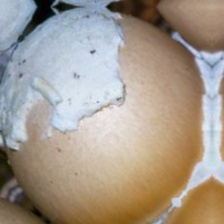

In [5]:
# Compter le nombre d'images
total_files = 0

for i in range(len(df.index)):
    PATH = os.path.join(mo_db_path,str(df.index[i]))
    for filename in os.listdir(PATH):
        total_files = total_files+1

r = random.randint(1, total_files-1)
print("Voici l'un des", total_files, "fichiers, il est très appétissant :")
champi = list(data_dir.glob('*/*.jpg'))
PIL.Image.open(str(champi[r]))

la première classe, ayant l'identifiant 373 correspond à l'espece des Amanita muscaria stocké dans :  ../../data/LAYER2/MO/373


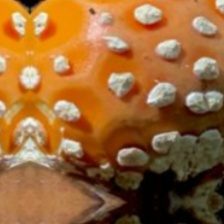

In [6]:
print("la première classe, ayant l'identifiant", df.index[0], "correspond à l'espece des", df['name'][df.index[0]], "stocké dans : ", os.path.join(mo_db_path,str(df.index[0])))
muscaria = list(data_dir.glob(str(df.index[0])+'/*'))
PIL.Image.open(str(muscaria[0]))

### Créer un ensemble de données

In [7]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 144000 files belonging to 14 classes.
Using 115200 files for training.
Found 144000 files belonging to 14 classes.
Using 28800 files for validation.


2024-07-26 11:54:02.967296: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


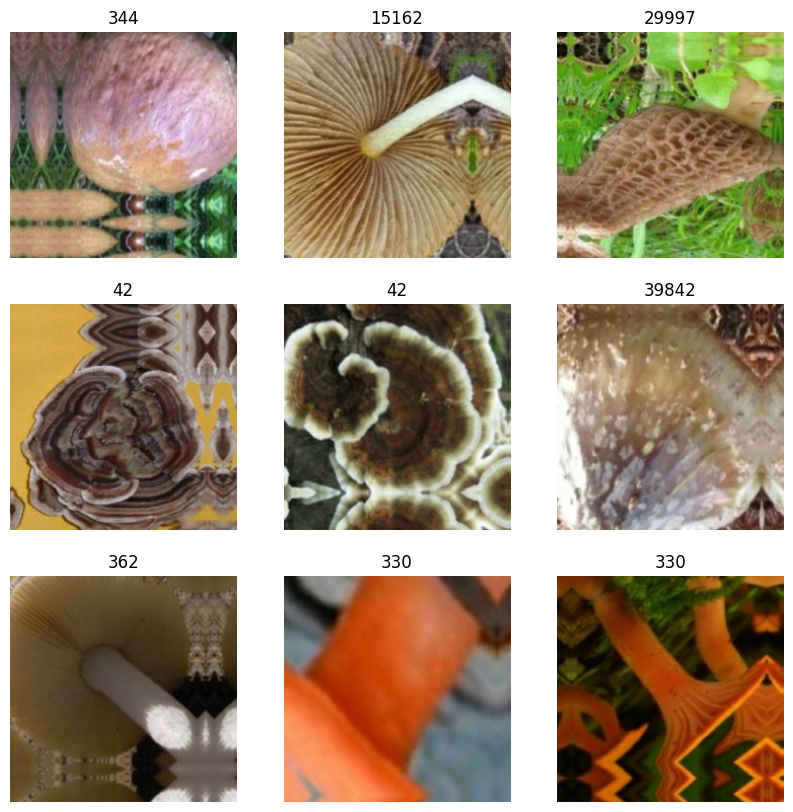

In [8]:
# Visualiser un échantillon

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [12]:
for images in train_ds.take(1):
  print(class_names)

['1174', '15162', '1540', '2749', '29997', '330', '344', '362', '373', '382', '39842', '42', '50164', '63454']


In [13]:
class_names

['1174',
 '15162',
 '1540',
 '2749',
 '29997',
 '330',
 '344',
 '362',
 '373',
 '382',
 '39842',
 '42',
 '50164',
 '63454']

> L' image_batch est un tenseur d'un lot de *batch_size* images de forme *h x w x 3* (la dernière dimension fait référence aux canaux de couleur RVB).

> Le label_batch est un tenseur des labels correspondants aux *batch_size* images.

> Vous pouvez appeler *.numpy()* sur l'un de ces tenseurs pour les convertir en numpy.ndarray

In [15]:
np.save('class_names.npy', class_names) # Sauvegarde des labels

# Création du CNN

## Configuration pour les performances afin d'éviter une saturation de la RAM

In [ ]:
options = tf.data.Options()

# Stop magic stuff that eats up RAM:
options.autotune.enabled = False
options.experimental_distribute.auto_shard_policy = (
  tf.data.experimental.AutoShardPolicy.OFF)
options.experimental_optimization.inject_prefetch = False

train_ds = train_ds.with_options(options)
val_ds = val_ds.with_options(options)


## Créer le CNN

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Input(shape=(img_height, img_width,3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,448,046 (24.60 MB)

 Trainable params: 6,448,046 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

## Entrainement

Epoch 1/5
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 1721s 478ms/step - accuracy: 0.5228 - loss: 1.4658 - val_accuracy: 0.7244 - val_loss: 0.8069
Epoch 2/5
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 1736s 482ms/step - accuracy: 0.7691 - loss: 0.6829 - val_accuracy: 0.7865 - val_loss: 0.6644
Epoch 3/5
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 1912s 531ms/step - accuracy: 0.8768 - loss: 0.3635 - val_accuracy: 0.8185 - val_loss: 0.6116
Epoch 4/5
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 2226s 618ms/step - accuracy: 0.9286 - loss: 0.2139 - val_accuracy: 0.8149 - val_loss: 0.7481
Epoch 5/5
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 2188s 608ms/step - accuracy: 0.9501 - loss: 0.1501 - val_accuracy: 0.8219 - val_loss: 0.8133


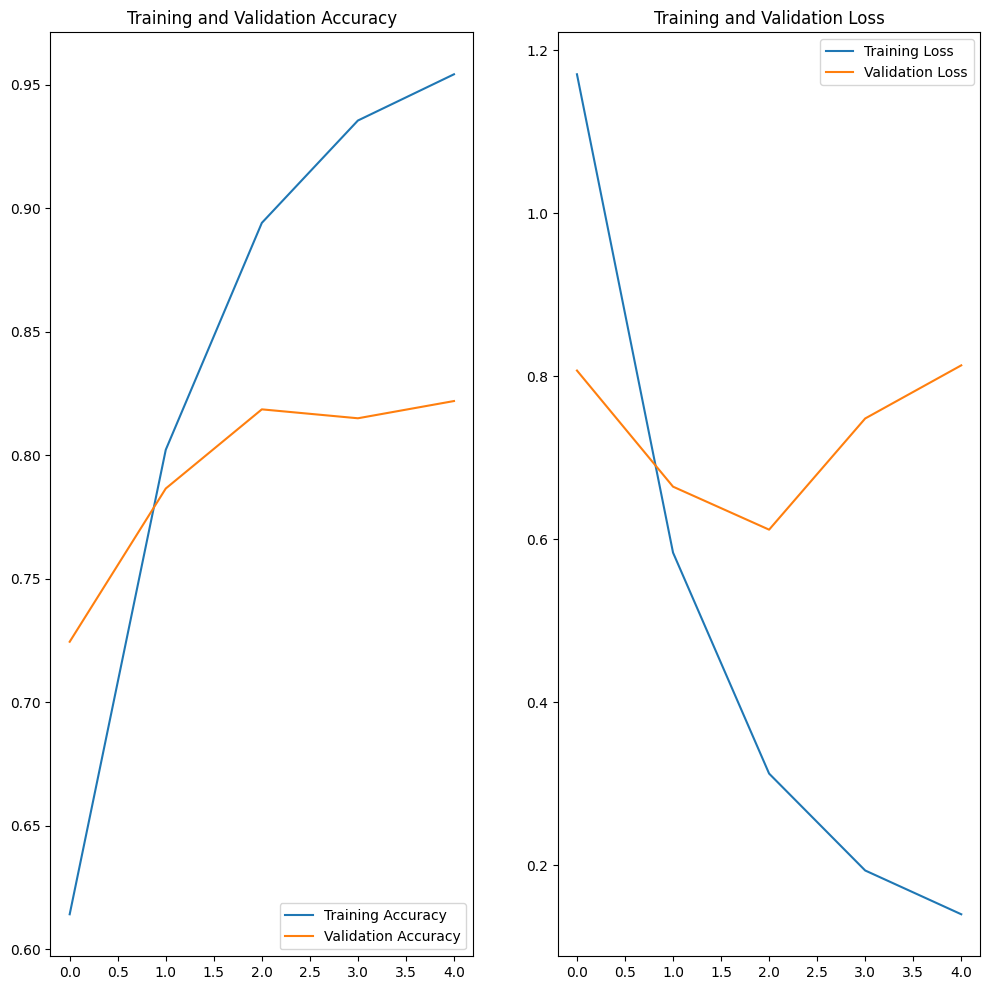

In [ ]:
epochs=5

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Show results
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show();

# Envoi des résultats sur le serveur de tracking MLflow

In [ ]:
# Initialisation de l'URL
mlflow_server_uri = "https://champi.heuzef.com"

# Imports et paramétrage de MLflow
from mlflow import MlflowClient
import mlflow
import setuptools
import requests

mlflow.set_tracking_uri(mlflow_server_uri)
mlflow.set_experiment("champi") # Le nom du projet

def is_mlflow_tracking_server_available(mlflow_server_uri):
  try:
    response = requests.get(mlflow_server_uri)
    if response.status_code == 200:
      return True
    else:
      return False
  except requests.exceptions.RequestException:
    return False

if is_mlflow_tracking_server_available(mlflow_server_uri):
  print("Le serveur de tracking MLflow est disponible :", mlflow_server_uri)
else:
  print("Le serveur de tracking MLflow n'est pas disponible.")

requests.get(mlflow_server_uri)

Le serveur de tracking MLflow est disponible : https://champi.heuzef.com


<Response [200]>

In [ ]:
run_name = "heuzef_lenet_001"

with mlflow.start_run(run_name=run_name) as run:
    mlflow.log_param("epochs", epochs)
    mlflow.log_metric("train_loss", history.history["loss"][-1])
    mlflow.log_metric("train_accuracy", history.history["accuracy"][-1])
    mlflow.log_metric("val_loss", history.history["val_loss"][-1])
    mlflow.log_metric("val_accuracy", history.history["val_accuracy"][-1])
    mlflow.keras.log_model(model, artifact_path=run_name+"_artifacts")
    mlflow.end_run()

2024/07/24 18:06:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
/home/heuzef/GIT/jan24_cds_mushrooms/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
